In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import statsmodels.formula.api as smf
from scipy import stats

In [2]:
df = pd.read_csv('dataset_for_dano_fuel.csv')
df['week'] = pd.to_datetime(df['week'])

# Основная информация о датасете

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448132 entries, 0 to 448131
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   week                448132 non-null  datetime64[ns, UTC]
 1   party_rk            448132 non-null  int64              
 2   service_fee_amt     448132 non-null  int64              
 3   gmv                 448132 non-null  float64            
 4   orders_cnt          448132 non-null  float64            
 5   bundle_name         448132 non-null  object             
 6   cashback_category   448132 non-null  float64            
 7   platform            448132 non-null  object             
 8   liters              448132 non-null  float64            
 9   first_order_date    448132 non-null  object             
 10  entries_cnt         442770 non-null  float64            
 11  region              0 non-null       float64            
 12  gender_cd       

In [4]:
print('Строк:', df.shape[0])
print('Уникальных пользователей:', df['party_rk'].nunique())
print('Всего заказов:', df['orders_cnt'].sum())
print(df['week'].min(), '-', df['week'].max())

Строк: 448132
Уникальных пользователей: 99877
Всего заказов: 610771.0
2025-03-30 21:00:00+00:00 - 2025-05-25 21:00:00+00:00


In [5]:
BG_COLOR = '#1f1f1f'
TEXT_COLOR = 'white'
ACCENT_COLOR = '#fedd2c'
GRID_COLOR = '#444444'
DARK_ACCENT = '#3d3d3d'
SECONDARY_COLOR = '#a6a6a6'
DARK_BASE = '#2b2b2b'
OTHER_COLOR = '#e0e0e0'

plt.rcParams.update({
    'figure.facecolor': BG_COLOR,
    'axes.facecolor': BG_COLOR,
    'text.color': TEXT_COLOR,
    'axes.labelcolor': TEXT_COLOR,
    'xtick.color': TEXT_COLOR,
    'ytick.color': TEXT_COLOR,
    'axes.edgecolor': TEXT_COLOR,
    'grid.color': GRID_COLOR,
    'grid.linestyle': '--',
    'grid.alpha': 0.3,
    'font.size': 14
})

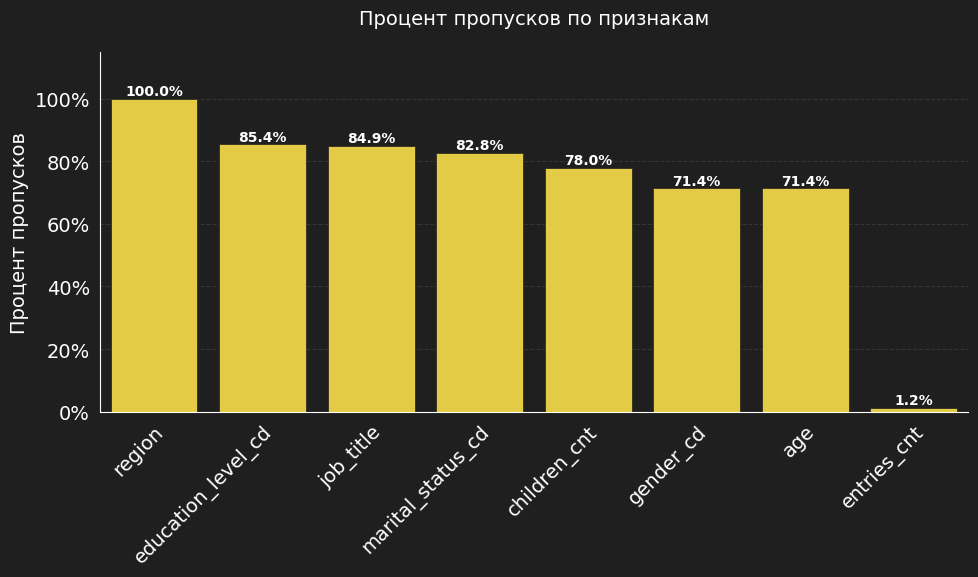

In [6]:
null_data = df.isnull().mean() * 100
null_data = null_data[null_data > 0].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(max(10, len(null_data) * 0.8), 6))

fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)

sns.barplot(
    x=null_data.index,
    y=null_data.values,
    color=ACCENT_COLOR,
    edgecolor=BG_COLOR,
    linewidth=0.5,
    ax=ax
)

ax.set_title('Процент пропусков по признакам', color=TEXT_COLOR, fontsize=14, pad=20)
ax.set_ylabel('Процент пропусков', color=TEXT_COLOR)
ax.set_xlabel('', color=TEXT_COLOR)

ax.tick_params(axis='both', colors=TEXT_COLOR)
ax.tick_params(axis='x', rotation=45)

plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

sns.despine(top=True, right=True, left=False, bottom=False, ax=ax)
ax.spines['bottom'].set_color(TEXT_COLOR)
ax.spines['left'].set_color(TEXT_COLOR)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))

for i, v in enumerate(null_data.values):
    ax.text(
        i,
        v + 0.2,
        f'{v:.1f}%',
        color=TEXT_COLOR,
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

ax.set_ylim(0, max(null_data.values) * 1.15)

ax.grid(axis='y', color=TEXT_COLOR, alpha=0.1, linestyle='--')

plt.tight_layout()
plt.show()

# Очистка выбросов

In [7]:
df_full_len = len(df)
df = df[df['gmv']< 25000]
df = df[df['liters']< 2500]
df = df[(df['entries_cnt']>=df['orders_cnt']) | (df['entries_cnt'].isna())]
df = df[((df['age']>=18) & (df['age'] <= 90)) | (df['age'].isna())]
df = df[df['orders_cnt']<=7]
df = df[df['cashback_category']<10]
df_clean_len = len(df)
(df_full_len-df_clean_len)/df_full_len

0.06352146242624941

In [8]:
df0 = df[df['liters']>0].copy()
df0['gmv_per_liter'] = df0['gmv'] / df0['liters']
print(f'Средняя цена за литр: {df0['gmv_per_liter'].mean().item():.2f}')

Средняя цена за литр: 60.85


# Предварительный анализ

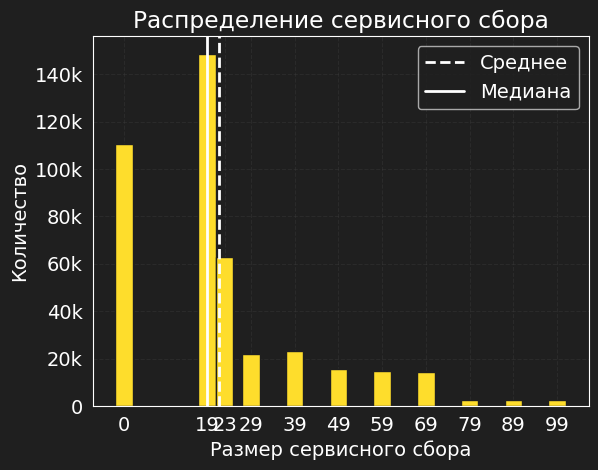

In [9]:
counts = df['service_fee_amt'].value_counts().sort_index()

def thousands_formatter(x, pos):
    if x >= 1000:
        return f'{x/1000:.0f}k'
    return f'{x:.0f}'
formatter = FuncFormatter(thousands_formatter)

plt.bar(counts.index, counts.values, color=ACCENT_COLOR, edgecolor=BG_COLOR, width=4)

mean_fee = df['service_fee_amt'].mean()
median_fee = df['service_fee_amt'].median()

plt.axvline(mean_fee, linestyle='--', linewidth=2, label='Среднее', color='white')
plt.axvline(median_fee, linestyle='-', linewidth=2, label='Медиана', color='white')

ax = plt.gca()

plt.xticks(counts.index)

ax.yaxis.set_major_formatter(formatter)

plt.legend()
plt.xlabel('Размер сервисного сбора')
plt.ylabel('Количество')
plt.title('Распределение сервисного сбора')
plt.show()

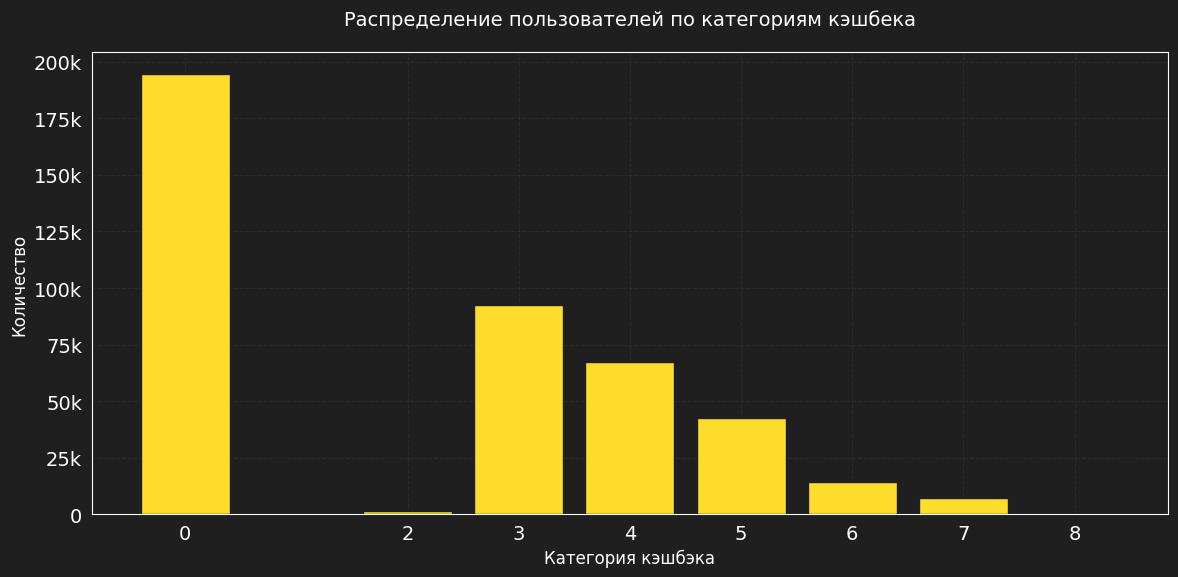

In [10]:
filtered_df = df[df['cashback_category'] < 20]

counts = filtered_df['cashback_category'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(
    counts.index,
    counts.values,
    color=ACCENT_COLOR,
    edgecolor=BG_COLOR,
    width=0.8,
    zorder=3
)

ax.set_title('Распределение пользователей по категориям кэшбека', fontsize=14, pad=20)
ax.set_xlabel('Категория кэшбэка', fontsize=12)
ax.set_ylabel('Количество', fontsize=12)

ax.set_xticks(counts.index)
ax.set_xticklabels(counts.index.astype(int))

formatter = FuncFormatter(thousands_formatter)
ax.yaxis.set_major_formatter(formatter)


ax.grid(axis='y', zorder=0)
plt.tight_layout()
plt.show()

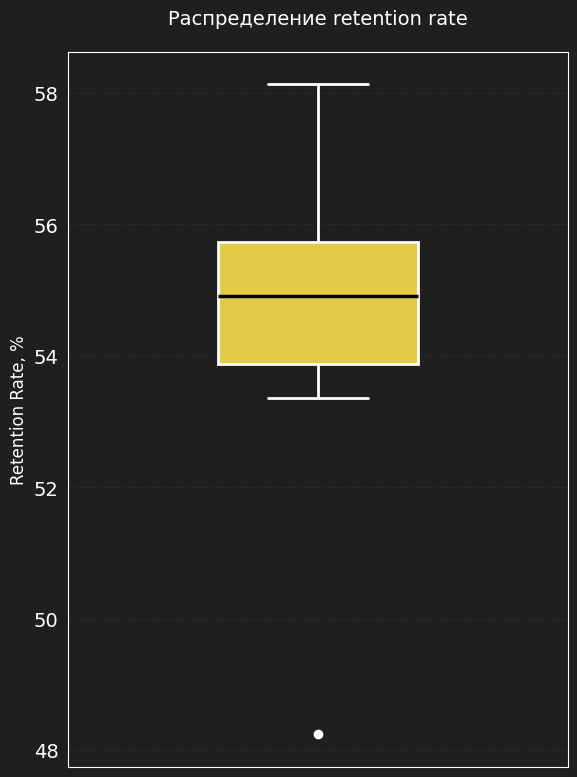

In [11]:
weeks = sorted(df['week'].unique())
retention_data = []

for i in range(1, len(weeks)):
    curr_week = weeks[i]
    prev_week = weeks[i-1]
    users_prev = set(df[df['week'] == prev_week]['party_rk'])
    users_curr = set(df[df['week'] == curr_week]['party_rk'])
    retained_users = users_prev.intersection(users_curr)

    if len(users_prev) > 0:
        retention_rate = len(retained_users) / len(users_prev)
        retention_data.append({
            'week': curr_week,
            'retention_rate': retention_rate
        })

df_retention = pd.DataFrame(retention_data)

plt.figure(figsize=(6, 8))

sns.boxplot(
    y=df_retention['retention_rate'],
    color=ACCENT_COLOR,
    width=0.4,
    linewidth=2,
    flierprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "white"},
    medianprops={"color": "black", "linewidth": 2.5},
    whiskerprops={"color": TEXT_COLOR},
    capprops={"color": TEXT_COLOR},
    boxprops={"edgecolor": TEXT_COLOR}
)

plt.ylabel('', fontsize=12)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x*100:.0f}"))

plt.grid(axis='y', linestyle='--')
plt.title('Распределение retention rate', fontsize=14, pad=20)
plt.ylabel('Retention Rate, %', fontsize=12)
plt.tight_layout()
plt.show()

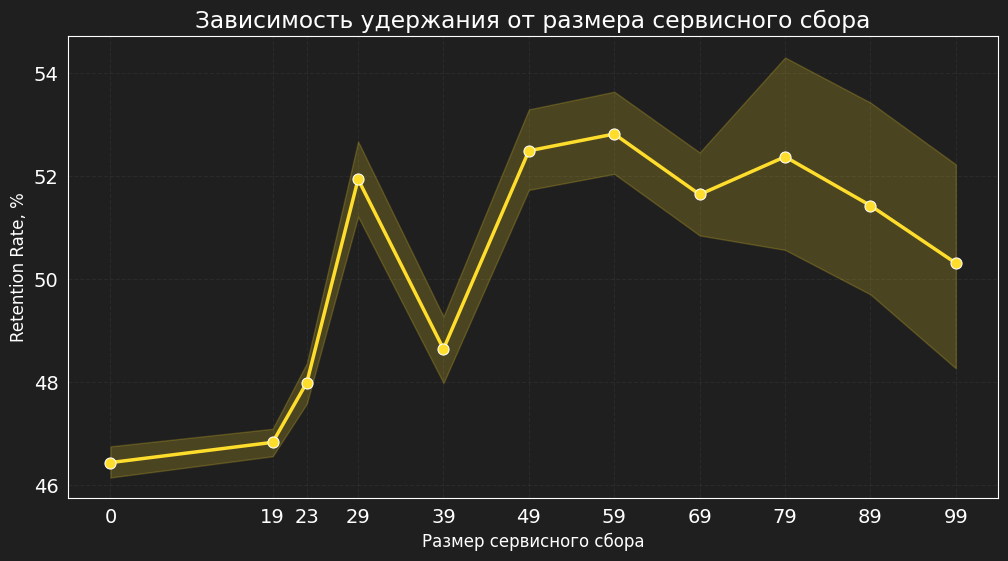

In [12]:
df_next_week = df[['party_rk', 'week']].drop_duplicates()
df_next_week['prev_week'] = df_next_week['week'] - pd.Timedelta(days=7)

retention_data = df.merge(
    df_next_week,
    left_on=['party_rk', 'week'],
    right_on=['party_rk', 'prev_week'],
    how='left',
    indicator=True
)

retention_data['is_retained'] = (retention_data['_merge'] == 'both').astype(int)

plt.figure(figsize=(12, 6))

sns.lineplot(
    data=retention_data,
    x='service_fee_amt',
    y='is_retained',
    color=ACCENT_COLOR,
    marker='o',
    markersize=8,
    linewidth=2.5,
    errorbar=('ci', 95),
    err_kws={'alpha': 0.2}
)

plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)

valid_fees = [0, 19, 23, 29, 39, 49, 59, 69, 79, 89, 99]
plt.xticks(valid_fees)
plt.grid(True)

ax = plt.gca()

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x*100:.0f}"))

ax.yaxis.set_major_locator(mtick.MultipleLocator(0.02))
plt.title('Зависимость удержания от размера сервисного сбора')
plt.ylabel('Retention Rate, %')
plt.xlabel('Размер сервисного сбора')
plt.show()

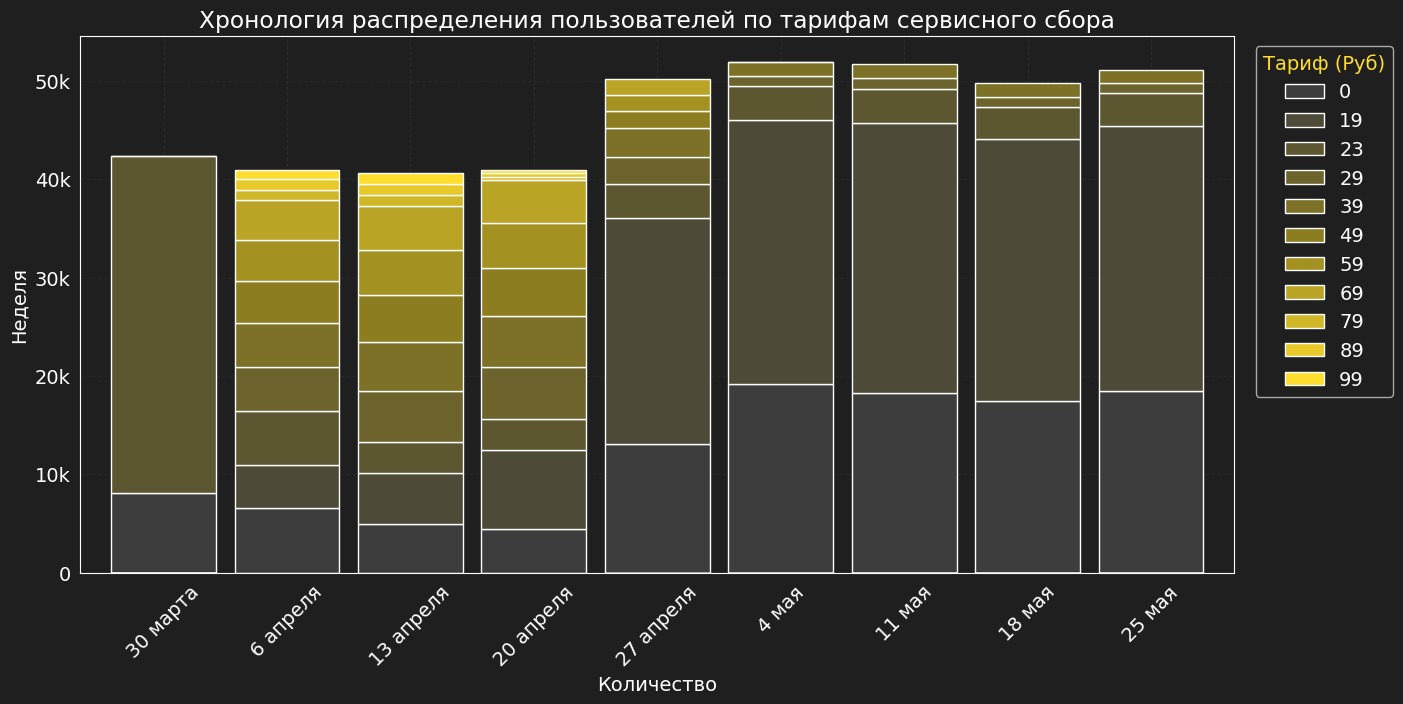

In [13]:
pivot_fee = df.groupby(['week', 'service_fee_amt'])['party_rk'].count().unstack().fillna(0)

colors_list = ["#3d3d3d", "#8c7e20", "#fedd2c"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("dark_yellow_gradient", colors_list, N=len(pivot_fee.columns))

def thousands_formatter(x, pos):
    if x >= 1000:
        return f'{x/1000:.0f}k'
    return f'{x:.0f}'

month_map = {
    1: 'янв', 2: 'фев', 3: 'марта', 4: 'апреля', 5: 'мая', 6: 'июня',
    7: 'июля', 8: 'авг', 9: 'сент', 10: 'окт', 11: 'ноя', 12: 'дек'
}

fig, ax = plt.subplots(figsize=(14, 7))

pivot_fee.plot(kind='bar', stacked=True, colormap=custom_cmap, ax=ax, width=0.85)

ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))

new_labels = [f"{dt.day} {month_map[dt.month]}" for dt in pivot_fee.index]

ax.set_xticklabels(new_labels, rotation=45)

legend = ax.legend(title='Тариф (Руб)', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.setp(legend.get_title(), color=ACCENT_COLOR)

ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.ylabel('Неделя')
plt.xlabel('Количество')
plt.title('Хронология распределения пользователей по тарифам сервисного сбора')
plt.show()

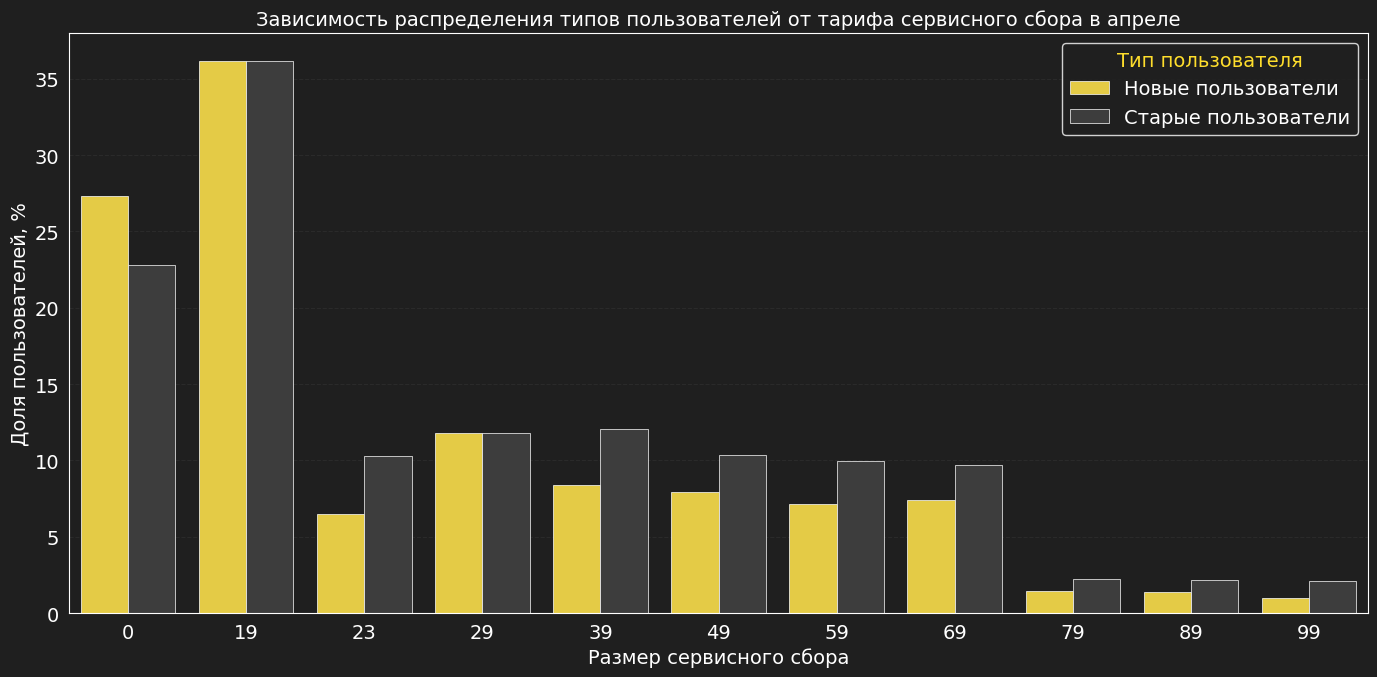

In [14]:
df['first_order_date'] = pd.to_datetime(df['first_order_date'])
april_data = df[df['week'].dt.month_name() == 'April'].copy()

april_data['user_type'] = april_data['first_order_date'].apply(
    lambda x: 'Новые пользователи' if x >= pd.to_datetime('2025-04-01') else 'Старые пользователи'
)

counts = april_data.groupby(['user_type', 'service_fee_amt'])['party_rk'].nunique().reset_index(name='count')
total_counts = april_data.groupby('user_type')['party_rk'].nunique().reset_index(name='total')
merged = counts.merge(total_counts, on='user_type')
merged['share'] = (merged['count'] / merged['total']) * 100

custom_palette = {
    'Новые пользователи': ACCENT_COLOR,
    'Старые пользователи': DARK_ACCENT
}

fig, ax = plt.subplots(figsize=(14, 7))

sns.barplot(
    data=merged,
    x='service_fee_amt',
    y='share',
    hue='user_type',
    palette=custom_palette,
    edgecolor=TEXT_COLOR,
    linewidth=0.5,
    ax=ax
)

ax.set_title('Зависимость распределения типов пользователей от тарифа сервисного сбора в апреле', fontsize=14, color=TEXT_COLOR)
ax.set_ylabel('Доля пользователей, %')
ax.set_xlabel('Размер сервисного сбора')

legend = ax.legend(title='Тип пользователя')
plt.setp(legend.get_title(), color=ACCENT_COLOR)
frame = legend.get_frame()
frame.set_facecolor(BG_COLOR)
frame.set_edgecolor(TEXT_COLOR)

ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

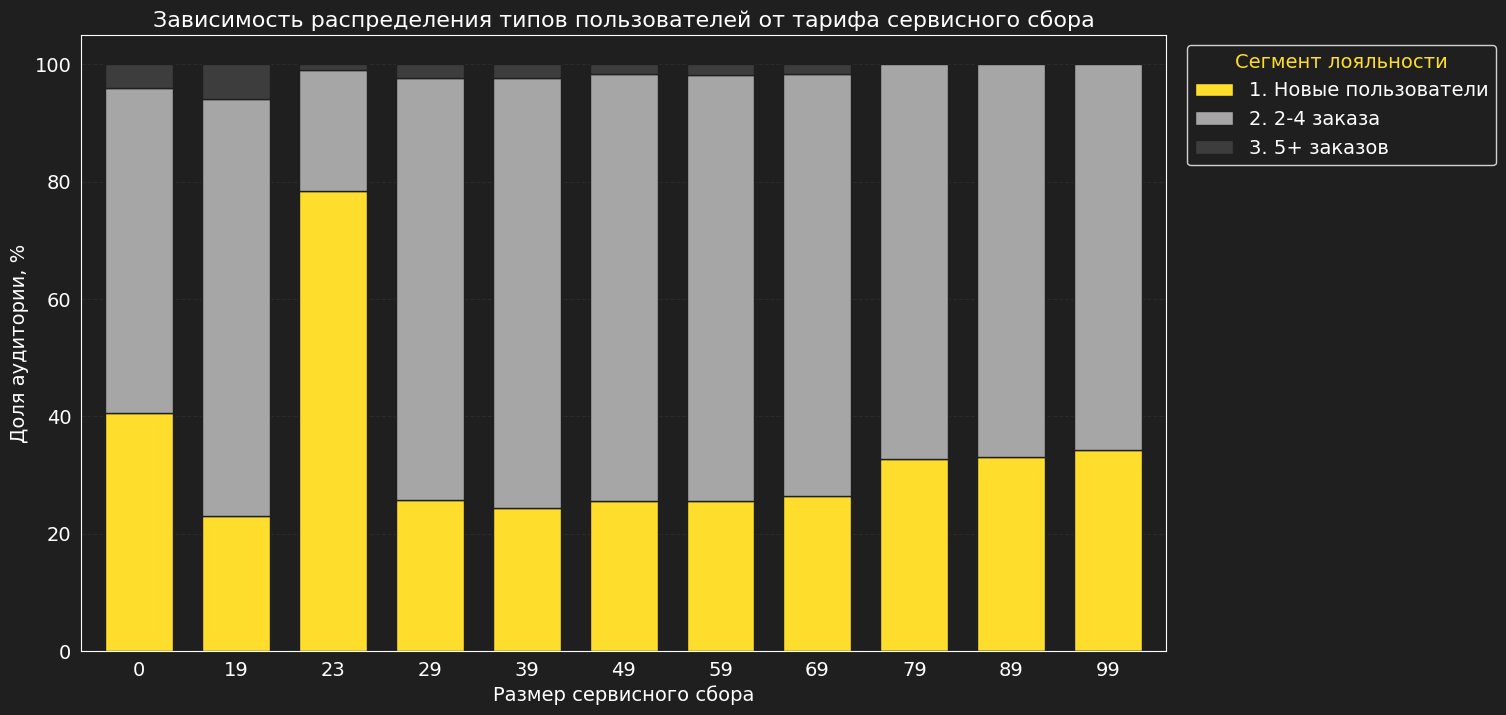

In [15]:
df_clean = df[df['week'] < '2025-05-01'].copy()
df_clean = df_clean.sort_values(['party_rk', 'week'])

df_clean['user_experience'] = df_clean.groupby('party_rk').cumcount()

def define_loyalty(cnt):
    if cnt == 0: return '1. Новые пользователи'
    if cnt <= 3: return '2. 2-4 заказа'
    return '3. 5+ заказов'

df_clean['loyalty_segment'] = df_clean['user_experience'].apply(define_loyalty)

purchases = df_clean[['party_rk', 'week']].drop_duplicates()
purchases['next_week'] = purchases['week'] + pd.Timedelta(weeks=1)

retention_check = purchases.merge(
    purchases[['party_rk', 'week']],
    left_on=['party_rk', 'next_week'],
    right_on=['party_rk', 'week'],
    how='left',
    indicator=True,
    suffixes=('', '_next')
)

df_clean['is_retained'] = (df_clean.merge(
    retention_check[['party_rk', 'week', '_merge']],
    on=['party_rk', 'week'],
    how='left'
)['_merge'] == 'both').astype(int)

palette_dict = {
    '1. Новые пользователи': ACCENT_COLOR,
    '2. 2-4 заказа': SECONDARY_COLOR,
    '3. 5+ заказов': DARK_ACCENT
}
colors_list = [palette_dict['1. Новые пользователи'],
               palette_dict['2. 2-4 заказа'],
               palette_dict['3. 5+ заказов']]

fig, ax = plt.subplots(figsize=(14, 8), sharex=True)

structure = df_clean.groupby(['service_fee_amt', 'loyalty_segment']).size().reset_index(name='count')
structure_pivot = structure.pivot(index='service_fee_amt', columns='loyalty_segment', values='count')
structure_pct = structure_pivot.div(structure_pivot.sum(axis=1), axis=0) * 100
cols_order = ['1. Новые пользователи', '2. 2-4 заказа', '3. 5+ заказов']
structure_pct = structure_pct[cols_order]

structure_pct.plot(
    kind='bar',
    stacked=True,
    color=colors_list,
    edgecolor=BG_COLOR,
    linewidth=1,
    width=0.7,
    ax=ax
)

ax.set_title('Зависимость распределения типов пользователей от тарифа сервисного сбора', fontsize=16, color=TEXT_COLOR)
ax.set_ylabel('Доля аудитории, %')
ax.grid(axis='x', visible=False)
ax.set_xlabel('Размер сервисного сбора')
plt.xticks(rotation=0)
leg1 = ax.legend(title='Сегмент лояльности', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.setp(leg1.get_title(), color=ACCENT_COLOR)
leg1.get_frame().set_facecolor(BG_COLOR)
leg1.get_frame().set_edgecolor(TEXT_COLOR)

plt.show()

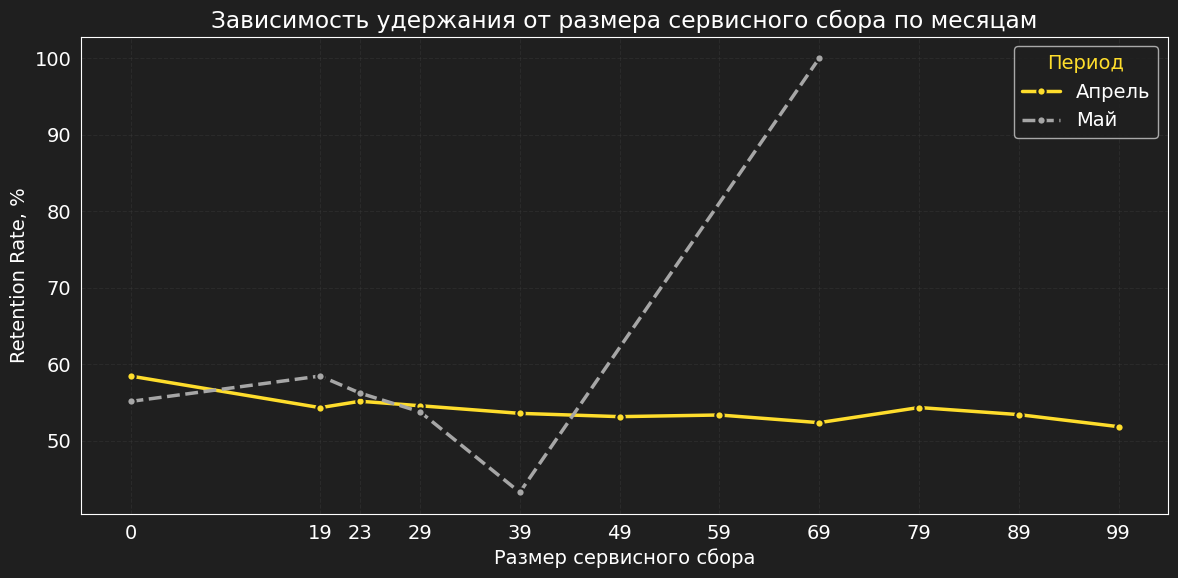

In [16]:
sorted_weeks = sorted(df['week'].unique())
retention_stats = []

for i in range(len(sorted_weeks) - 1):
    curr_week = sorted_weeks[i]
    next_week = sorted_weeks[i+1]
    curr_df = df[df['week'] == curr_week]
    next_week_users = set(df[df['week'] == next_week]['party_rk'].unique())

    for fee, group in curr_df.groupby('service_fee_amt'):
        curr_users = set(group['party_rk'].unique())
        returned_users_count = len(curr_users.intersection(next_week_users))
        total_users_count = len(curr_users)
        retention_rate = returned_users_count / total_users_count if total_users_count > 0 else 0

        retention_stats.append({
            'week': curr_week,
            'service_fee_amt': fee,
            'retention_rate': retention_rate
        })

retention_df = pd.DataFrame(retention_stats)
retention_df['month_name'] = retention_df['week'].dt.month_name()
retention_df['period'] = retention_df['month_name'].map({
    'April': 'Апрель',
    'May': 'Май'
})

final_plot_data = retention_df.groupby(['period', 'service_fee_amt'])['retention_rate'].mean().reset_index()
final_plot_data = final_plot_data[final_plot_data['period'].notna()]

fig, ax = plt.subplots(figsize=(12, 6))

periods = ['Апрель', 'Май']
colors = [ACCENT_COLOR, SECONDARY_COLOR]
styles = ['-', '--']

for i, period in enumerate(periods):
    subset = final_plot_data[final_plot_data['period'] == period]

    ax.plot(
        subset['service_fee_amt'],
        subset['retention_rate'],
        label=period,
        color=colors[i],
        linestyle=styles[i],
        linewidth=2.5,
        marker='o',
        markersize=6,
        markeredgecolor=BG_COLOR,
        markeredgewidth=1.5
    )

ax.set_xlabel('Размер сервисного сбора')
ax.set_ylabel('Retention Rate, %')
plt.title('Зависимость удержания от размера сервисного сбора по месяцам')

valid_fees = sorted(final_plot_data['service_fee_amt'].unique())
ax.set_xticks(valid_fees)

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x*100:.0f}"))

legend = ax.legend(title='Период')
plt.setp(legend.get_title(), color=ACCENT_COLOR)

ax.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_65012/2084099172.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_labels = heatmap_data.applymap(lambda x: f'{x:,.0f}'.replace(',', ' '))


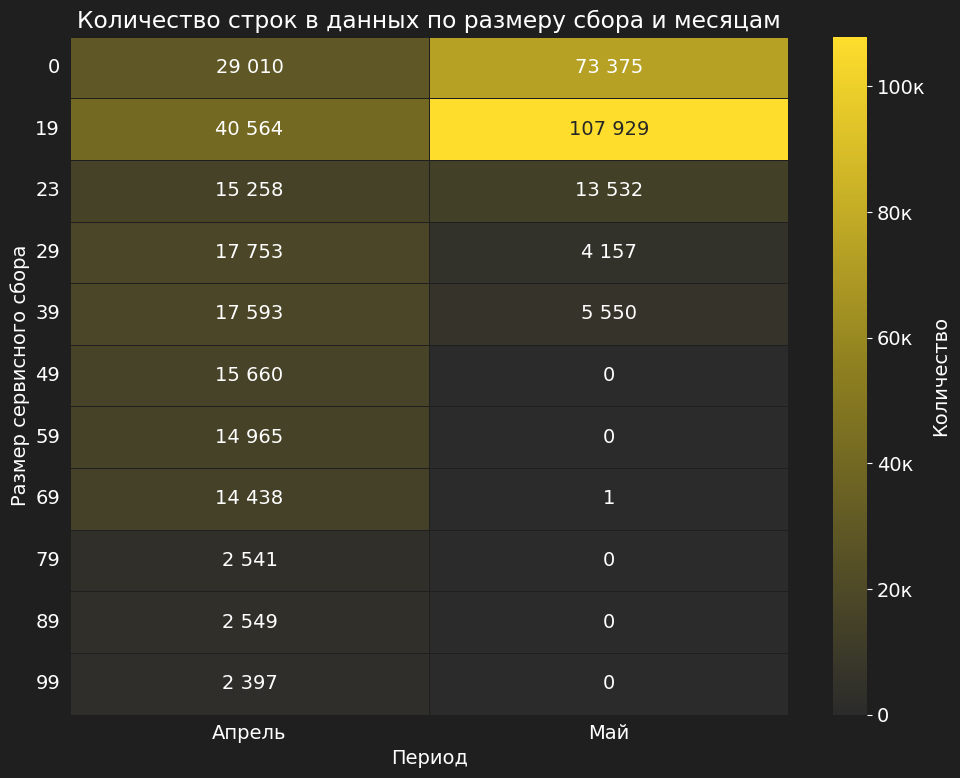

In [17]:
df['month_name'] = df['week'].dt.month_name()
df['period'] = df['month_name'].map({'April': 'Апрель', 'May': 'Май'})
df_filtered = df[df['period'].notna()].copy()

heatmap_data = df_filtered.groupby(['service_fee_amt', 'period'])['party_rk'].count().unstack().fillna(0)
cols_order = ['Апрель', 'Май']
heatmap_data = heatmap_data[cols_order]

annot_labels = heatmap_data.applymap(lambda x: f'{x:,.0f}'.replace(',', ' '))

def k_formatter(x, pos):
    if x >= 1000:
        return f'{x/1000:.0f}к'
    return f'{x:.0f}'

colors = [DARK_BASE, "#8c7e20", ACCENT_COLOR]
cmap_name = 'dark_yellow_heat'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    heatmap_data,
    annot=annot_labels,
    fmt='',
    cmap=custom_cmap,
    linewidths=0.5,
    linecolor=BG_COLOR,
    cbar_kws={'label': ''},
    ax=ax
)

ax.set_xlabel('Период')
ax.set_ylabel('Размер сервисного сбора')
ax.set_title('Количество строк в данных по размеру сбора и месяцам')

plt.yticks(rotation=0)

cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Количество')
cbar.ax.yaxis.set_major_formatter(mtick.FuncFormatter(k_formatter))
cbar.ax.yaxis.set_tick_params(color=TEXT_COLOR)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=TEXT_COLOR)

plt.tight_layout()
plt.show()

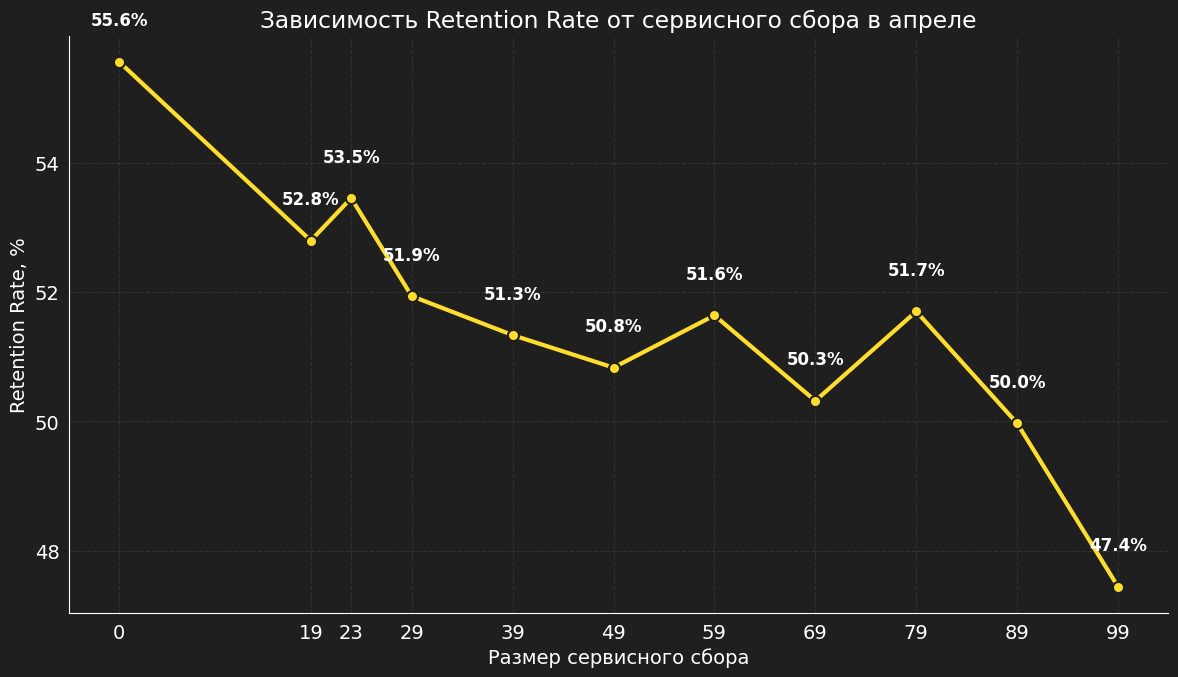

In [18]:
mass_segment = df[(df['liters'] >= 20) & (df['liters'] <= 50)].copy()
mass_segment['month'] = mass_segment['week'].dt.month
april_data = mass_segment[mass_segment['month'] == 4].copy()

base_cohort = april_data[['party_rk', 'week', 'service_fee_amt']].drop_duplicates()
all_activity = df[['party_rk', 'week']].drop_duplicates()
all_activity['prev_week'] = all_activity['week'] - pd.Timedelta(days=7)

merged = base_cohort.merge(
    all_activity,
    left_on=['party_rk', 'week'],
    right_on=['party_rk', 'prev_week'],
    how='left',
    indicator=True
)

merged['is_retained'] = (merged['_merge'] == 'both').astype(int)
retention_df = merged.groupby('service_fee_amt')['is_retained'].mean().reset_index()
retention_df.rename(columns={'is_retained': 'retention_rate'}, inplace=True)
retention_df = retention_df.sort_values('service_fee_amt')


plt.figure(figsize=(12, 7))

plt.plot(
    retention_df['service_fee_amt'],
    retention_df['retention_rate'],
    marker='o',
    color=ACCENT_COLOR,
    linewidth=3,
    markersize=8,
    markerfacecolor=ACCENT_COLOR,
    markeredgecolor=BG_COLOR,
    markeredgewidth=1.5
)

for x, y in zip(retention_df['service_fee_amt'], retention_df['retention_rate']):
    plt.text(
        x,
        y + 0.005,
        f"{y:.1%}",
        ha='center',
        va='bottom',
        fontweight='bold',
        color=TEXT_COLOR,
        fontsize=12
    )

plt.title('Зависимость Retention Rate от сервисного сбора в апреле')
plt.xlabel('Размер сервисного сбора')
plt.ylabel('Retention Rate, %')

ax = plt.gca()

plt.xticks(retention_df['service_fee_amt'])

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x*100:.0f}"))
ax.yaxis.set_major_locator(mtick.MultipleLocator(0.02))
plt.grid(True, linestyle='--', alpha=0.5)


sns.despine()

plt.tight_layout()
plt.show()

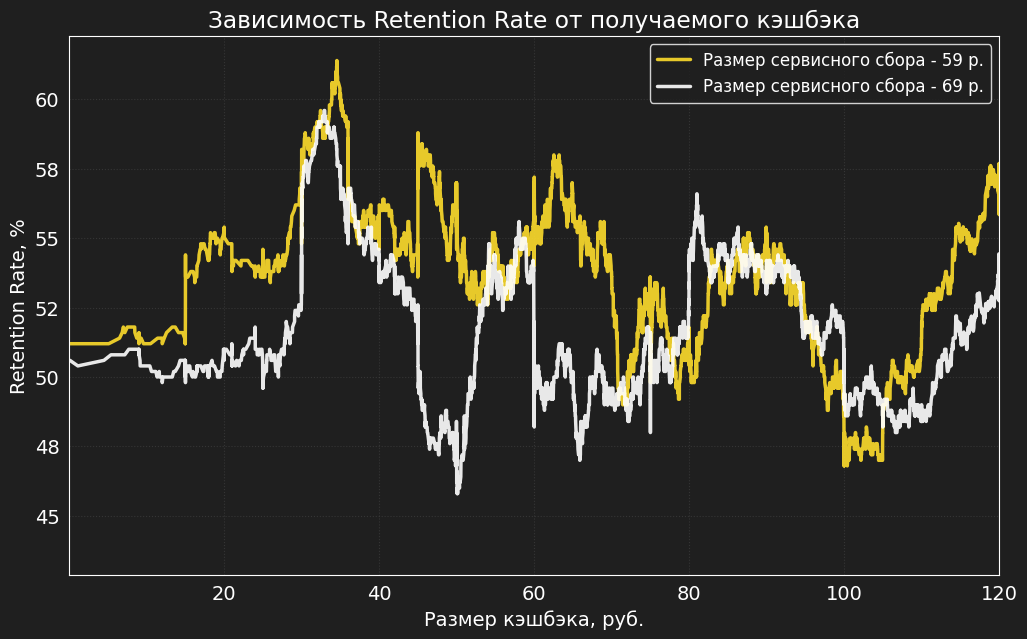

In [19]:
activity = df[['party_rk', 'week']].drop_duplicates()
activity['prev_week'] = activity['week'] - pd.Timedelta(days=7)

df_analysis = df.merge(
    activity,
    left_on=['party_rk', 'week'],
    right_on=['party_rk', 'prev_week'],
    how='left',
    indicator=True
)

df_analysis['is_retained'] = (df_analysis['_merge'] == 'both').astype(int)
df_analysis['cashback_proxy'] = df_analysis['gmv'] * (df_analysis['cashback_category'] / 100)

subset = df_analysis[
    (df_analysis['service_fee_amt'].isin([59, 69])) &
    (df_analysis['cashback_proxy'] >= 0) &
    (df_analysis['cashback_proxy'] <= 120)
].copy()

def calculate_rolling_retention(df_sub, fee, window_size=1000):
    data = df_sub[df_sub['service_fee_amt'] == fee].sort_values('cashback_proxy')
    data['rolling_ret'] = data['is_retained'].rolling(window=window_size, min_periods=100, center=True).mean()
    return data['cashback_proxy'], data['rolling_ret']

plt.figure(figsize=(12, 7))

w_size = 500

x59, y59 = calculate_rolling_retention(subset, 59, window_size=w_size)
plt.plot(x59, y59, label='Размер сервисного сбора - 59 р.', color=ACCENT_COLOR, linewidth=2.5, alpha=0.9)

x69, y69 = calculate_rolling_retention(subset, 69, window_size=w_size)
plt.plot(x69, y69, label='Размер сервисного сбора - 69 р.', color='#ffffff', linewidth=2.5, alpha=0.9)

plt.xlabel('Размер кэшбэка, руб.')
plt.ylabel('Retention Rate, %')
plt.title('Зависимость Retention Rate от получаемого кэшбэка')

plt.legend(fontsize=12, frameon=True, facecolor=BG_COLOR, edgecolor=TEXT_COLOR)
plt.grid(True, linestyle=':', alpha=0.6)

plt.xlim(0.001, 120)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x*100:.0f}"))

plt.show()

# Математическая модель

In [20]:
df_clean = df[df['bundle_name'] != 'Private'].copy()
df_clean['week_clean'] = pd.to_datetime(df_clean['week']).dt.tz_localize(None)
df_clean = df_clean[df_clean['week_clean'] < pd.to_datetime("2025-05-20")]

purchases = df_clean[['party_rk', 'week_clean']].drop_duplicates()
purchases['next_week'] = purchases['week_clean'] + pd.Timedelta(weeks=1)

retention_check = purchases.merge(purchases[['party_rk', 'week_clean']],
                                  left_on=['party_rk', 'next_week'],
                                  right_on=['party_rk', 'week_clean'],
                                  how='left', indicator=True)

retention_check['is_retained'] = (retention_check['_merge'] == 'both').astype(int)

model_data = df_clean.merge(retention_check[['party_rk', 'week_clean_x', 'is_retained']],
                            left_on=['party_rk', 'week_clean'],
                            right_on=['party_rk', 'week_clean_x'])

df_analysis = model_data[
    (model_data['week_clean_x'].dt.month == 4) &
    (model_data['service_fee_amt'] >= 23) &
    (model_data['service_fee_amt'] <= 69)
].copy()

--- Чувствительность по Категориям Кэшбэка ---
  Cashback Cat  Ret @ 59  Ret @ 69  Delta (pp)   P-value      Вывод
1          3.0  0.577421  0.541851   -3.556951  0.000550  ✅ ЗНАЧИМО
2          5.0  0.483131  0.477252   -0.587845  0.694240      ❌ Шум
0          0.0  0.504983  0.507753    0.276978  0.752733      ❌ Шум
3          4.0  0.549451  0.565502    1.605163  0.489885      ❌ Шум


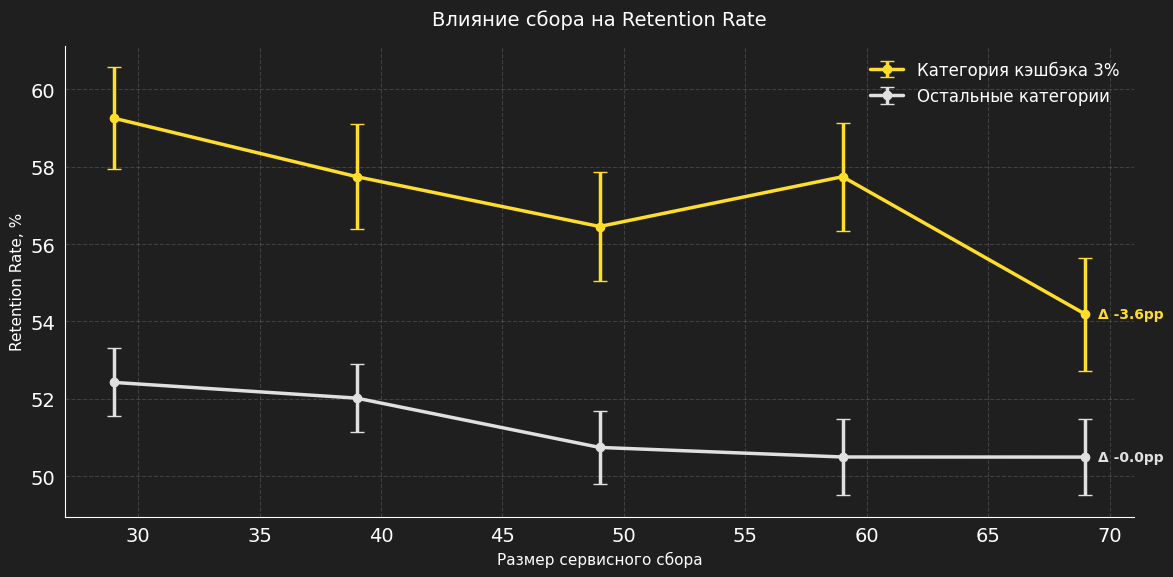

In [21]:
def analyze_cashback(df):
    results = []
    top_cats = df['cashback_category'].value_counts().nlargest(5).index.tolist()

    for cat in top_cats:
        sub = df[df['cashback_category'] == cat]

        d59 = sub[sub['service_fee_amt'] == 59]
        d69 = sub[sub['service_fee_amt'] == 69]

        n1, p1 = len(d59), d59['is_retained'].mean()
        n2, p2 = len(d69), d69['is_retained'].mean()

        if n1 > 500 and n2 > 500:
            p_pool = (p1 * n1 + p2 * n2) / (n1 + n2)
            se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
            z = (p1 - p2) / se
            p_val = stats.norm.sf(abs(z)) * 2

            signif = "✅ ЗНАЧИМО" if p_val < 0.05 else "❌ Шум"

            results.append({
                'Cashback Cat': str(cat),
                'Ret @ 59': p1,
                'Ret @ 69': p2,
                'Delta (pp)': (p2 - p1) * 100,
                'P-value': p_val,
                'Вывод': signif
            })

    return pd.DataFrame(results).sort_values('Delta (pp)')

print("--- Чувствительность по Категориям Кэшбэка ---")
res_cashback = analyze_cashback(df_analysis)
print(res_cashback)

worst_cat = float(res_cashback.iloc[0]['Cashback Cat'])


df_analysis['is_sensitive_cat'] = np.where(
    df_analysis['cashback_category'] == worst_cat,
    f'Категория кэшбэка {int(worst_cat)}%',
    'Остальные категории'
)

groups = [f'Категория кэшбэка {int(worst_cat)}%', 'Остальные категории']
colors = [ACCENT_COLOR, OTHER_COLOR]

fig, ax = plt.subplots(figsize=(12, 6), facecolor=BG_COLOR)
ax.set_facecolor(BG_COLOR)

for i, g in enumerate(groups):
    data = df_analysis[df_analysis['is_sensitive_cat'] == g]
    stats_df = data.groupby('service_fee_amt')['is_retained'].agg(['mean', 'count'])

    stats_df = stats_df.loc[stats_df.index.intersection([29, 39, 49, 59, 69])]

    stats_df['ci'] = 1.96 * np.sqrt(stats_df['mean'] * (1 - stats_df['mean']) / stats_df['count'])

    ax.errorbar(stats_df.index, stats_df['mean'], yerr=stats_df['ci'],
                label=g, color=colors[i],
                marker='o', markersize=6, linewidth=2.5,
                capsize=5, ecolor=colors[i])

    if 69 in stats_df.index and 59 in stats_df.index:
        val_69 = stats_df.loc[69, 'mean']
        val_59 = stats_df.loc[59, 'mean']
        ax.text(69.5, val_69, f"Δ {(val_69-val_59)*100:.1f}pp",
                color=colors[i], fontweight='bold', va='center', fontsize=10)

ax.set_title(f'Влияние сбора на Retention Rate',
             color=TEXT_COLOR, fontsize=14, pad=15)
ax.set_ylabel('Retention Rate, %', color=TEXT_COLOR, fontsize=11)
ax.set_xlabel('Размер сервисного сбора', color=TEXT_COLOR, fontsize=11)

ax.grid(True, linestyle='--', alpha=0.15, color='#ffffff')

ax.tick_params(axis='x', colors=TEXT_COLOR)
ax.tick_params(axis='y', colors=TEXT_COLOR)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(TEXT_COLOR)
ax.spines['left'].set_color(TEXT_COLOR)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x*100:.0f}"))
legend = ax.legend(frameon=False, fontsize=12)
plt.setp(legend.get_texts(), color=TEXT_COLOR)

plt.tight_layout()
plt.show()

# Проверка на устойчивость

In [22]:
df_hypothesis = model_data[
    model_data['service_fee_amt'].isin([59, 69]) &
    (model_data['week_clean_x'].dt.month == 4)
].copy()

df_hypothesis['is_high_fee'] = (df_hypothesis['service_fee_amt'] == 69).astype(int)

df_hypothesis['is_cashback_3'] = (df_hypothesis['cashback_category'] == 3.0).astype(int)

df_hypothesis['gender_cd'] = df_hypothesis['gender_cd'].fillna('Unknown')
df_hypothesis['age'] = df_hypothesis['age'].fillna(df_hypothesis['age'].median())
df_hypothesis['children_cnt'] = df_hypothesis['children_cnt'].fillna(0)
df_hypothesis.dropna(subset=['platform'], inplace=True)

model_formula = """
is_retained ~ is_high_fee + is_cashback_3 + is_high_fee:is_cashback_3 +
              age + children_cnt + C(platform) + C(gender_cd) + C(education_level_cd)
"""

logit_model = smf.logit(formula=model_formula, data=df_hypothesis).fit(method='bfgs')

print(logit_model.summary())

params = logit_model.params
conf = logit_model.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print("\n--- Odds Ratios (Экспонента коэффициентов) ---")
print(np.exp(conf))

         Current function value: 0.676893
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:            is_retained   No. Observations:                 4382
Model:                          Logit   Df Residuals:                     4367
Method:                           MLE   Df Model:                           14
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:                0.006939
Time:                        22:01:03   Log-Likelihood:                -2966.1
converged:                      False   LL-Null:                       -2986.9
Covariance Type:            nonrobust   LLR p-value:                 0.0001511
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0

/home/kirill/PycharmProjects/DANO/.venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1330: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/kirill/PycharmProjects/DANO/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kirill/PycharmProjects/DANO/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
